In [2]:
#!/usr/bin/env python
################################################################
#  Copyright (C) 2015 OpenEye Scientific Software, Inc.
################################################################
from __future__ import print_function
import os, sys
import pandas as pd
import scipy.stats as stats
import scipy as sci
import numpy as np
import pylab
get_ipython().magic(u'matplotlib inline')

### OpenEye section: load up relevant libs and depiction functions

We will use depictMatch, which highlights the SMARTS matches but not yet the SMIRKS map indices

In [3]:
import openeye.oechem as oechem
import openeye.oedepict as oedepict
from IPython.display import display

In [4]:
def depictMatch(mol, match, width=500, height=200):
    from IPython.display import Image
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetDepictOrientation( oedepict.OEDepictOrientation_Horizontal)
    dopt.SetSuppressHydrogens(False)
    oedepict.OEPrepareDepiction(mol, dopt)
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    opts.SetTitleLocation(oedepict.OETitleLocation_Bottom)
    disp = oedepict.OE2DMolDisplay(mol, opts)
    hstyle = oedepict.OEHighlightStyle_Color
    hcolor = oechem.OEColor(oechem.OEMagenta)
    oedepict.OEAddHighlighting(disp, hcolor, hstyle, match)
    ofs = oechem.oeosstream()
    oedepict.OERenderMolecule(ofs, 'png', disp)
    ofs.flush()
    return Image(data = "".join(ofs.str()))

### Load lib for chemical environments

Note full path to the library over in the smarty git tree

In [5]:
import imp
smirky = imp.load_source('environment','../../smarty/environment.py')

### Chemical groups we might use

In [6]:
chemGroups = [ ('ewg1', '[#7,#8!-1,#16!-1,F,Cl,Br,I]'),
               ('ewg1di', '[#7!X1,#8!X1,#16!X1]') ]

### initialize a torsion with brute force lists for atoms and bonds

In [7]:
#torsionEnv1 = smirky.TorsionChemicalEnvironment([['#6'], ['X4']], [['-'], None], [['#6'], ['X4']], [['-'], None], [['#6'], ['X4']], [['-'], None], [['#6'], ['X4']])
#torsionEnv1 = smirky.TorsionChemicalEnvironment([['#6'], ['X4']], [['!#', '!@'], None], [['#6'], ['X4']], [None,None], [['#6'], ['X4']], [['-'], None], [['#6'], ['X4']])
torsionEnv1 = smirky.TorsionChemicalEnvironment([['#6'], ['X4']], [['!#', '!@'], None], [['#6'], ['X4']], [['-',':','='],['@']], [['#6'], ['X4']], [['-'], None], [['#6'], ['X4']])
print( torsionEnv1.asSMIRKS() )

[#6;X4:1]!#,!@[#6;X4:2]-,:,=;@[#6;X4:3]-[#6;X4:4]


### torsions from atom and bond sublists

In [19]:
# Sublists
A_any = [None,None]
A_C = [ ['#6'], None]
A_Ctet = [ ['#6X4'], None]
A_O = [ ['#8'], None]
A_OEth = [ ['#8X2'], ['H0','+0']]
A_OH = [ ['#8X2'], ['H1','+0'] ]
A_H = [ ['H'], None]
Bsngl = [ ['-'], None]
BnoRing = [ ['!@'], None]
B_any = [ None, None]
ewg1 = [['#7','#8!-1','#16!-1','F','Cl','Br','I'], None]
#ewg1 = [['ewg1'],None]

In [20]:
# torsions from sublists
torsionEnv2 = smirky.TorsionChemicalEnvironment( A_Ctet,B_any,A_Ctet,Bsngl,A_OH,B_any,A_any )
torsionEnv3 = smirky.TorsionChemicalEnvironment( A_OEth,B_any,A_Ctet,Bsngl,A_OH,B_any,A_any )
torsionEnv4 = smirky.TorsionChemicalEnvironment( A_OEth,B_any,A_Ctet,Bsngl,A_O,B_any,A_any )
print( torsionEnv4.asSMIRKS() )

[#8X2;H0;+0:1]~[#6X4:2]-[#8:3]~[*:4]


In [25]:
# angles from sublists and explicit lists
angEnv1 = smirky.AngleChemicalEnvironment( A_OEth,B_any,A_Ctet,Bsngl,A_OH)
angEnv2 = smirky.AngleChemicalEnvironment( A_Ctet,B_any,A_Ctet,Bsngl,A_Ctet)
angEnv3 = smirky.AngleChemicalEnvironment( A_Ctet,B_any,A_Ctet,BnoRing,A_Ctet)
angEnv4 = smirky.AngleChemicalEnvironment( A_Ctet,B_any,A_Ctet,BnoRing,A_Ctet)
angEnv4.addAtom(angEnv4.atom3)
angEnv4.addAtom(angEnv4.atom2)
print( angEnv3.asSMIRKS() )

[#6X4:1]~[#6X4:2]!@[#6X4:3]


In [26]:
Smarts = angEnv4.asSMIRKS()
modSmarts = oechem.OESmartsLexReplace( Smarts, chemGroups)
if Smarts != modSmarts:
    print("orig     smarts: %s\nmodified smarts: %s" % (Smarts, modSmarts))
qmol = oechem.OEQMol()
if not oechem.OEParseSmarts( qmol, modSmarts ):
    print( 'OEParseSmarts failed')
ss = oechem.OESubSearch( qmol)

In [27]:
fileprefix= 'AlkEthOH_dvrs1'
ifs = oechem.oemolistream(fileprefix+'.oeb')
#ofs = oechem.oemolostream(fileprefix+'_filt1.smi')

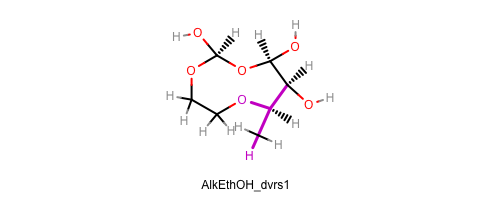

2 3 7 6 21 
1 2 0 3 0 

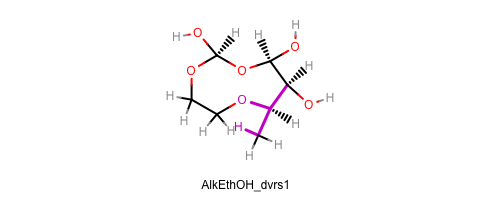

2 3 7 6 22 
1 2 0 3 0 

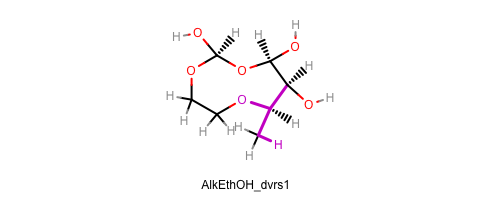

2 3 7 6 23 
1 2 0 3 0 

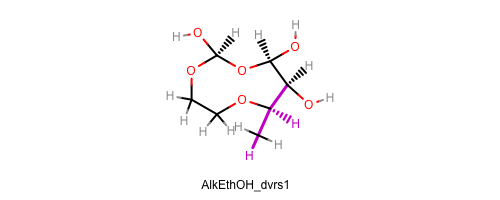

2 3 18 6 21 
1 2 0 3 0 

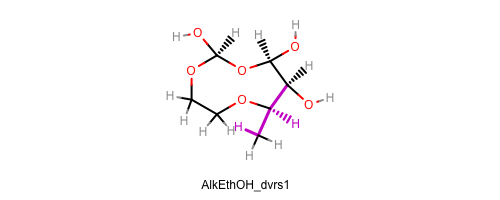

2 3 18 6 22 
1 2 0 3 0 

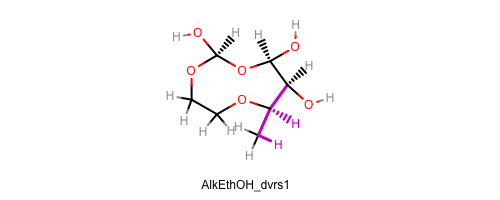

2 3 18 6 23 
1 2 0 3 0 

In [28]:
mol = oechem.OEMol()
for mol in ifs.GetOEMols():
    goodMol = True
    oechem.OEPrepareSearch(mol, ss)
    unique = True
    for match in ss.Match(mol, unique):
        display( depictMatch(mol, match))
        for ma in match.GetAtoms():
            print(ma.target.GetIdx(), end=" ")
        print('')
        for ma in match.GetAtoms():
            print(ma.pattern.GetMapIdx(), end=" ")

In [37]:
ifs.close()
#ofs.close()